In [18]:
#!pip install tf-keras
#!pip install scikit-learn  

In [19]:
import os
import shutil
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
import sys
import numpy as np
sys.path.append('aux_scripts.py')

i = "3classes"

## NN creation and training

### Split the data into training and validation sets

In [20]:
# Function to clear a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate an empty directory

# Function to copy files to target directories
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# Function to split dataset
def split_dataset(source_dir, test_size=0.2):
    files = os.listdir(source_dir)
    files = [os.path.join(source_dir, f) for f in files]
    train_files, temp_files = train_test_split(files, test_size=test_size, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    return train_files, val_files, test_files

# Split the dataset
def split_and_copy(train_dir, val_dir, test_dir):

    # Clear the train, val, and test directories before splitting
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    mask_train_files, mask_val_files, mask_test_files = split_dataset(mask_dir)
    no_mask_train_files, no_mask_val_files, no_mask_test_files = split_dataset(no_mask_dir)
    wrong_mask_train_files, wrong_mask_val_files, wrong_mask_test_files = split_dataset(wrong_mask_dir)

    # Copy files to train/val/test directories
    copy_files(mask_train_files, os.path.join(train_dir, 'mask'))
    copy_files(mask_val_files, os.path.join(val_dir, 'mask'))
    copy_files(mask_test_files, os.path.join(test_dir, 'mask'))

    copy_files(no_mask_train_files, os.path.join(train_dir, 'no_mask'))
    copy_files(no_mask_val_files, os.path.join(val_dir, 'no_mask'))
    copy_files(no_mask_test_files, os.path.join(test_dir, 'no_mask'))
    
    copy_files(wrong_mask_train_files, os.path.join(train_dir, 'wrong_mask'))
    copy_files(wrong_mask_val_files, os.path.join(val_dir, 'wrong_mask'))
    copy_files(wrong_mask_test_files, os.path.join(test_dir, 'wrong_mask'))

In [ ]:
# Paths to directories
dataset_dir = '../dataset'
train_dir = '../dataset_split/train'
val_dir = '../dataset_split/val'
test_dir = '../dataset_split/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

mask_dir = os.path.join(dataset_dir, 'mask')
no_mask_dir = os.path.join(dataset_dir, 'no_mask')
wrong_mask_dir = os.path.join(dataset_dir, 'wrong_mask')

split_and_copy(train_dir, val_dir, test_dir)

# Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

image_size = 150

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical', shuffle=False)

# Build the CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),


    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 200 

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore the weights of the best epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate when validation loss plateaus
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6          # Set a floor for the learning rate
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks= [early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save(f'mask_detector_model_{i}.h5')

# Print training summary
print("Model trained and saved as 'mask_detector_model.h5'")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 3243 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 407 images belonging to 3 classes.
Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 367ms/step - accuracy: 0.4837 - loss: 1.0404 - val_accuracy: 0.4790 - val_loss: 0.9115 - learning_rate: 0.0010
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 413ms/step - accuracy: 0.5204 - loss: 0.9395 - val_accuracy: 0.8321 - val_loss: 0.8057 - learning_rate: 0.0010
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - accuracy: 0.5712 - loss: 0.8570 - val_accuracy: 0.7827 - val_loss: 0.7980 - learning_rate: 0.0010
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - accuracy: 0.5730 - loss: 0.8556 - val_accuracy: 0.8420 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - accuracy: 0.6160 - loss: 0.8434 - val_accuracy: 0.8321 - val_loss: 0.6383 - learning_rate: 0.0010
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step - accuracy: 0.6934 - loss: 0.7702 - val_

Test Loss: 0.3763519525527954
Test Accuracy: 0.9017199277877808
Model trained and saved as 'mask_detector_model.h5'
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9488 - loss: 0.3465
Test Loss: 0.3763519525527954
Test Accuracy: 0.9017199277877808


### Test the model on the test set

Load the model

In [22]:
## load the model
model = tf.keras.models.load_model(f'mask_detector_model_{i}.h5')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,869 (433.09 KB)

 Trainable params: 110,867 (433.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Test the model on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


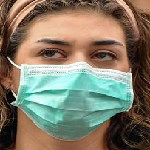

Image: mix_mask_3.jpg_face_1.png - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


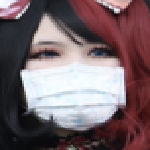

Image: w_mask_2.png_face_2.png - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


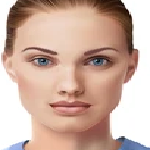

Image: test2.png_face_1.png - Prediction: No Mask (Probabilities: [0.00170798 0.9961527  0.00213935])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


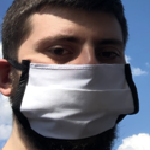

Image: w_mask_1.png_face_1.png - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


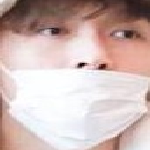

Image: mask_1659.jpg - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


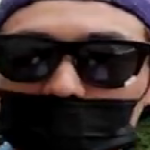

Image: mask_1812.png - Prediction: Mask (Probabilities: [0.6162241  0.30693612 0.07683975])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


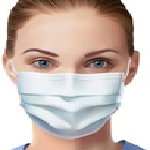

Image: test2.png_face_2.png - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


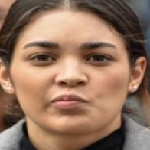

Image: mix_mask_3.jpg_face_2.png - Prediction: No Mask (Probabilities: [2.614265e-04 9.991714e-01 5.671844e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


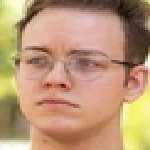

Image: test3.png_face_1.png - Prediction: No Mask (Probabilities: [1.9226832e-04 9.9934405e-01 4.6369972e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


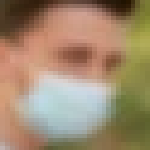

Image: test3.png_face_2.png - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


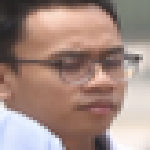

Image: mix_mask_2.png_face_2.png - Prediction: No Mask (Probabilities: [0.11704305 0.8460864  0.0368706 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


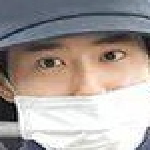

Image: mask_1849.jpg - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


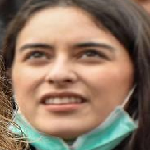

Image: mix_mask_3.jpg_face_3.png - Prediction: No Mask (Probabilities: [0.03577237 0.94769    0.01653762])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


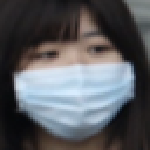

Image: w_mask_2.png_face_1.png - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


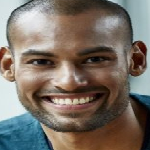

Image: test.jpg_face_1.png - Prediction: No Mask (Probabilities: [0.06143207 0.91388094 0.02468706])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


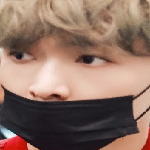

Image: mask_1658.jpg - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


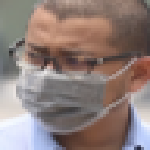

Image: mix_mask_2.png_face_1.png - Prediction: Mask (Probabilities: [0.7402425  0.20115763 0.0585999 ])


In [24]:
# Folder containing images to test
test_images_folder = '../dataset/images/cropped'  # Update with your folder path

class_labels = ['Mask', 'No Mask', 'Wrong Mask']  # Update class labels accordingly

for image_name in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, image_name)
    # Load and preprocess the image
    img = load_img(image_path, target_size=(image_size, image_size))  # Resize to match input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Get class index with highest probability
    label = class_labels[predicted_class]  # Map index to class label
    
    display(img)
    print(f"Image: {image_name} - Prediction: {label} (Probabilities: {prediction[0]})")
